### Import modules

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functools as ft

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_rows', 70000)
pd.set_option('display.max_columns', 40)
pd.set_option('display.width', 120)

### Explore & clean data

In [28]:
demographics= pd.read_csv('Train_Demographics.csv',na_values = "?")
policy = pd.read_csv('Train_Policy.csv', na_values = "?")
claim = pd.read_csv('Train_Claim.csv',na_values = "?")
vehicle = pd.read_csv('Train_Vehicle.csv', na_values = "?")
data = pd.read_csv('Traindata_with_Target.csv', na_values = "?")

(demographics.shape),(policy.shape),(claim.shape),(vehicle.shape),(data.shape)

((28836, 10), (28836, 10), (28836, 19), (115344, 3), (28836, 2))

In [63]:
#print(policy["PolicyAnnualPremium"].loc[policy["PolicyAnnualPremium"]==-1])
policy["PolicyAnnualPremium"].replace(to_replace=-1, value=np.nan, inplace=True)

#print(claim["TypeOfCollission"].loc[claim["TypeOfCollission"]=="?"])
claim["TypeOfCollission"].replace(to_replace="?", value=np.nan, inplace=True)

#print(claim["IncidentTime"].loc[claim["IncidentTime"]==-5])
claim["IncidentTime"].replace(to_replace=-5, value=np.nan, inplace=True)

#print(claim["PropertyDamage"].loc[claim["PropertyDamage"]=="?"])
claim["PropertyDamage"].replace(to_replace="?", value=np.nan, inplace=True)

#print(claim["Witnesses"].loc[claim["Witnesses"]=="MISSINGVALUE"])
claim["Witnesses"].replace(to_replace="MISSINGVALUE", value=np.nan, inplace=True)

#print(claim["PoliceReport"].loc[claim["PoliceReport"]=="?"])
claim["PoliceReport"].replace(to_replace="?", value=np.nan, inplace=True)

#print(vehicle["VehicleAttributeDetails"].loc[vehicle["VehicleAttributeDetails"]=="???"])
vehicle["VehicleAttributeDetails"].replace(to_replace="???", value=np.nan, inplace=True)



In [30]:
vehicle['VehicleAttribute'].value_counts()

VehicleID       28836
VehicleModel    28836
VehicleMake     28836
VehicleYOM      28836
Name: VehicleAttribute, dtype: int64

In [31]:
vid =  vehicle.loc[vehicle["VehicleAttribute"]=="VehicleID"]
vmodel = vehicle.loc[vehicle["VehicleAttribute"]=="VehicleModel"]
vmake = vehicle.loc[vehicle["VehicleAttribute"]=="VehicleMake"]
vyom = vehicle.loc[vehicle["VehicleAttribute"]=="VehicleYOM"]

vmodel=vmodel.rename(columns = {'VehicleAttribute':'VehicleAttribute2', 'VehicleAttributeDetails':'VehicleAttributeDetails2'})
vmake=vmake.rename(columns = {'VehicleAttribute':'VehicleAttribute3', 'VehicleAttributeDetails':'VehicleAttributeDetails3'})
vyom=vyom.rename(columns = {'VehicleAttribute':'VehicleAttribute4', 'VehicleAttributeDetails':'VehicleAttributeDetails4'})

dfs = [vid, vmodel,vmake,vyom]
vehicle_clean = ft.reduce(lambda left, right: pd.merge(left, right, on='CustomerID'), dfs)

vehicle_clean.shape

(28836, 9)

In [32]:
dfs = [data, claim, demographics, policy, vehicle_clean]
df = ft.reduce(lambda left, right: pd.merge(left, right, on='CustomerID'), dfs)
df.shape

(28836, 46)

In [33]:
# check first rows
df.head(4)

,CustomerID,ReportedFraud,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,...,CapitalGains,CapitalLoss,Country,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleAttribute,VehicleAttributeDetails,VehicleAttribute2,VehicleAttributeDetails2,VehicleAttribute3,VehicleAttributeDetails3,VehicleAttribute4,VehicleAttributeDetails4
0,Cust20065,N,2015-01-09,Multi-vehicle Collision,Rear Collision,Total Loss,Other,State9,City4,Location 1404,19.0,3,NaN,1,1,NaN,43973,9396,4698,29879,...,0,-42700,India,129186,432,1998-11-14,State2,250/500,2000,1142.87,0,own-child,VehicleID,Vehicle30662,VehicleModel,E400,VehicleMake,Mercedes,VehicleYOM,2005
1,Cust37589,N,2015-02-20,Single Vehicle Collision,Side Collision,Minor Damage,Ambulance,State4,City3,Location 1675,14.0,1,NaN,1,1,YES,62310,6539,6539,49232,...,51300,0,India,146710,128,2000-08-19,State2,100/300,1000,1274.38,2857344,own-child,VehicleID,Vehicle17183,VehicleModel,Highlander,VehicleMake,Toyota,VehicleYOM,2010
2,Cust24312,N,2015-01-14,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,State5,City2,Location 1546,21.0,3,NaN,0,0,NaN,42824,6069,6069,30686,...,0,0,India,133433,346,2000-06-23,State1,500/1000,745,1269.93,0,other-relative,VehicleID,Vehicle33982,VehicleModel,Passat,VehicleMake,Volkswagen,VehicleYOM,2002
3,Cust5493,Y,2015-01-07,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,State7,City4,Location 1413,12.0,3,YES,2,0,NaN,45672,253,5741,39678,...,47400,-56100,India,114614,42,1992-01-15,State2,100/300,986,1218.60,0,other-relative,VehicleID,Vehicle12299,VehicleModel,Highlander,VehicleMake,Toyota,VehicleYOM,2011


In [34]:
target = "ReportedFraud" # model objective

In [35]:
# check columns names
df.columns 

Index(['CustomerID', 'ReportedFraud', 'DateOfIncident', 'TypeOfIncident', 'TypeOfCollission', 'SeverityOfIncident',
       'AuthoritiesContacted', 'IncidentState', 'IncidentCity', 'IncidentAddress', 'IncidentTime', 'NumberOfVehicles',
       'PropertyDamage', 'BodilyInjuries', 'Witnesses', 'PoliceReport', 'AmountOfTotalClaim', 'AmountOfInjuryClaim',
       'AmountOfPropertyClaim', 'AmountOfVehicleDamage', 'InsuredAge', 'InsuredZipCode', 'InsuredGender',
       'InsuredEducationLevel', 'InsuredOccupation', 'InsuredHobbies', 'CapitalGains', 'CapitalLoss', 'Country',
       'InsurancePolicyNumber', 'CustomerLoyaltyPeriod', 'DateOfPolicyCoverage', 'InsurancePolicyState',
       'Policy_CombinedSingleLimit', 'Policy_Deductible', 'PolicyAnnualPremium', 'UmbrellaLimit',
       'InsuredRelationship', 'VehicleAttribute', 'VehicleAttributeDetails', 'VehicleAttribute2',
       'VehicleAttributeDetails2', 'VehicleAttribute3', 'VehicleAttributeDetails3', 'VehicleAttribute4',
       'VehicleAttribut

In [36]:
# check if duplicates
df.duplicated().sum() 

0

In [37]:
# identify NaN values
df[target].isnull().sum() 

0

In [38]:
# identify NaN values
df.isnull().sum() 

CustomerID                        0
ReportedFraud                     0
DateOfIncident                    0
TypeOfIncident                    0
TypeOfCollission               5162
SeverityOfIncident                0
AuthoritiesContacted              0
IncidentState                     0
IncidentCity                      0
IncidentAddress                   0
IncidentTime                     31
NumberOfVehicles                  0
PropertyDamage                10459
BodilyInjuries                    0
Witnesses                        46
PoliceReport                   9805
AmountOfTotalClaim                0
AmountOfInjuryClaim               0
AmountOfPropertyClaim             0
AmountOfVehicleDamage             0
InsuredAge                        0
InsuredZipCode                    0
InsuredGender                    30
InsuredEducationLevel             0
InsuredOccupation                 0
InsuredHobbies                    0
CapitalGains                      0
CapitalLoss                 

In [39]:
# labels counts
df[target].value_counts() 

N    21051
Y     7785
Name: ReportedFraud, dtype: int64

In [40]:
# suffle data
df = df.sample(frac=1).reset_index(drop=True)
# check first rows
df.head(4)

,CustomerID,ReportedFraud,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage,...,CapitalGains,CapitalLoss,Country,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleAttribute,VehicleAttributeDetails,VehicleAttribute2,VehicleAttributeDetails2,VehicleAttribute3,VehicleAttributeDetails3,VehicleAttribute4,VehicleAttributeDetails4
0,Cust27119,N,2015-01-15,Single Vehicle Collision,Rear Collision,Major Damage,Police,State7,City7,Location 1981,14.0,2,NO,1,3,NO,78378,13063,13063,52252,...,0,-22300,India,136240,431,1999-07-23,State1,500/1000,2000,1308.72,0,husband,VehicleID,Vehicle4582,VehicleModel,Maxima,VehicleMake,Dodge,VehicleYOM,2001
1,Cust5432,N,2015-01-21,Single Vehicle Collision,Side Collision,Major Damage,Police,State7,City2,Location 1165,12.0,1,YES,0,1,NO,56627,5810,11620,39197,...,0,-48500,India,114553,235,2000-03-24,State3,500/300,2000,1289.69,0,husband,VehicleID,Vehicle34734,VehicleModel,E400,VehicleMake,Mercedes,VehicleYOM,2005
2,Cust26799,N,2015-02-20,Single Vehicle Collision,Front Collision,Total Loss,Police,State9,City4,Location 1767,0.0,1,NaN,2,1,NaN,47587,6845,9054,31688,...,0,-31700,India,135920,46,1995-01-23,State2,100/300,1528,1685.21,0,wife,VehicleID,Vehicle21779,VehicleModel,Wrangler,VehicleMake,Jeep,VehicleYOM,1998
3,Cust30912,N,2015-01-13,Parked Car,Side Collision,Total Loss,Fire,State7,City6,Location 1751,15.0,2,YES,0,3,NO,17556,1720,3441,12395,...,0,0,India,140033,250,2000-08-11,State3,250/500,500,1528.77,0,own-child,VehicleID,Vehicle5318,VehicleModel,A3,VehicleMake,Saab,VehicleYOM,2009


In [41]:
# let's keep 6000 rows to speed up the development
df = df[:6000]
df.shape


(6000, 46)

### Extract features

In [42]:
def extract_num(df, target, keep_target=False, top_feature=None):
    
    num = list(df.select_dtypes(include="number").columns)
    
    inilen = len(num)
    
    if not top_feature is None:
        if not target in num:
            num.append(target)
        
        num = get_top_num(df[num], top_feature)
        
        if keep_target and not target in num:
            num.append(target)
            
        if keep_target == False and target in num:
            num.remove(target)
            
    if keep_target == False:
        if target in num:
            num.remove(target)
    
    if keep_target:
        if not target in num:
            num.append(target)

    print("Total Nr numerical features in initial dataset :" , inilen)

    if keep_target:
        print("Nr of numerical features for training :" , len(num)-1)
    else:
        print("Nr of numerical features for training :" , len(num))
            
    return num

def extract_cat(df, target, keep_target=False, top_feature=None):
    
    cat = list(df.select_dtypes(exclude="number").columns)
 
    inilen = len(cat)

    if not top_feature is None:
        if not target in cat:
            cat.append(target)
        
        cat = get_top_cat(df[cat], top_feature)
        
        if keep_target and not target in cat:
            cat.append(target)
            
        if keep_target == False and target in cat:
            cat.remove(target)
            
    if keep_target==False:
        if target in cat:
            cat.remove(target)
    
    if keep_target:
        if not target in cat:
            cat.append(target)
            
    print("Total Nr categorical features in initial dataset :" , inilen)

    if keep_target:
        print("Nr of categorical features for training :" , len(cat)-1)
    else:
        print("Nr of categorical features for training :" , len(cat))

    return cat

def get_top_num(df, nr_feat):
    
    # Encode labels 
    label_encoder = LabelEncoder()
    dfcorr = df.copy()
    dfcorr[target] = label_encoder.fit_transform(df[target])
    x, y = dfcorr.drop(columns=target), dfcorr[target]
    # calculate pearson coeff 
    correlations = x.corrwith(y).abs()
    correlations.sort_values(ascending=False, inplace=True)
    # keep only top features
    num = correlations.index.tolist()
    num = num[:nr_feat]
        
    return num

def get_top_cat(df, nr_feat):
    
    df = clean_cat(df.copy())
    #df = df.copy()
    df.dropna(inplace=True)
    # OrdinalEncoder object
    one = OrdinalEncoder()
    X = one.fit_transform(df.drop(columns=target))
    # label_encoder object 
    lab = LabelEncoder()
    # Encode labels 
    y = lab.fit_transform(df[target])
    
    from sklearn.feature_selection import SelectKBest, chi2
    selector = SelectKBest(chi2, k=nr_feat+1).fit(X, y)
    # Get columns to keep and create new dataframe with those only
    cols = selector.get_support(indices=True)
    df_top_cat = df.iloc[:,cols]
    cat = df_top_cat.columns.tolist()
    
    return cat

def clean_cat(df):
    df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns],
                              columns=['Variable', 'Unique Values']).set_index('Variable')
    reduced = df_uniques.loc[df_uniques['Unique Values'] / len(df) < 0.3]
    to_keep = reduced.index.tolist()
    
    return df[to_keep]


In [43]:
num = extract_num(df, target, keep_target=False, top_feature=None)
num

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 15


['IncidentTime',
 'NumberOfVehicles',
 'BodilyInjuries',
 'AmountOfInjuryClaim',
 'AmountOfPropertyClaim',
 'AmountOfVehicleDamage',
 'InsuredAge',
 'InsuredZipCode',
 'CapitalGains',
 'CapitalLoss',
 'InsurancePolicyNumber',
 'CustomerLoyaltyPeriod',
 'Policy_Deductible',
 'PolicyAnnualPremium',
 'UmbrellaLimit']

In [44]:
cat = extract_cat(df, target, keep_target=False, top_feature=None)
cat

Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 30


['CustomerID',
 'DateOfIncident',
 'TypeOfIncident',
 'TypeOfCollission',
 'SeverityOfIncident',
 'AuthoritiesContacted',
 'IncidentState',
 'IncidentCity',
 'IncidentAddress',
 'PropertyDamage',
 'Witnesses',
 'PoliceReport',
 'AmountOfTotalClaim',
 'InsuredGender',
 'InsuredEducationLevel',
 'InsuredOccupation',
 'InsuredHobbies',
 'Country',
 'DateOfPolicyCoverage',
 'InsurancePolicyState',
 'Policy_CombinedSingleLimit',
 'InsuredRelationship',
 'VehicleAttribute',
 'VehicleAttributeDetails',
 'VehicleAttribute2',
 'VehicleAttributeDetails2',
 'VehicleAttribute3',
 'VehicleAttributeDetails3',
 'VehicleAttribute4',
 'VehicleAttributeDetails4']

In [45]:
num = extract_num(df, target, keep_target=False, top_feature=5)
num

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 5


['InsurancePolicyNumber',
 'AmountOfVehicleDamage',
 'AmountOfPropertyClaim',
 'AmountOfInjuryClaim',
 'UmbrellaLimit']

In [46]:
cat = extract_cat(df, target, keep_target=False, top_feature=5)
cat

Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 5


['TypeOfCollission',
 'AuthoritiesContacted',
 'IncidentCity',
 'InsuredEducationLevel',
 'Country']

### Data visualization

In [47]:
num = extract_num(df, target, keep_target=True, top_feature=10)

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 10


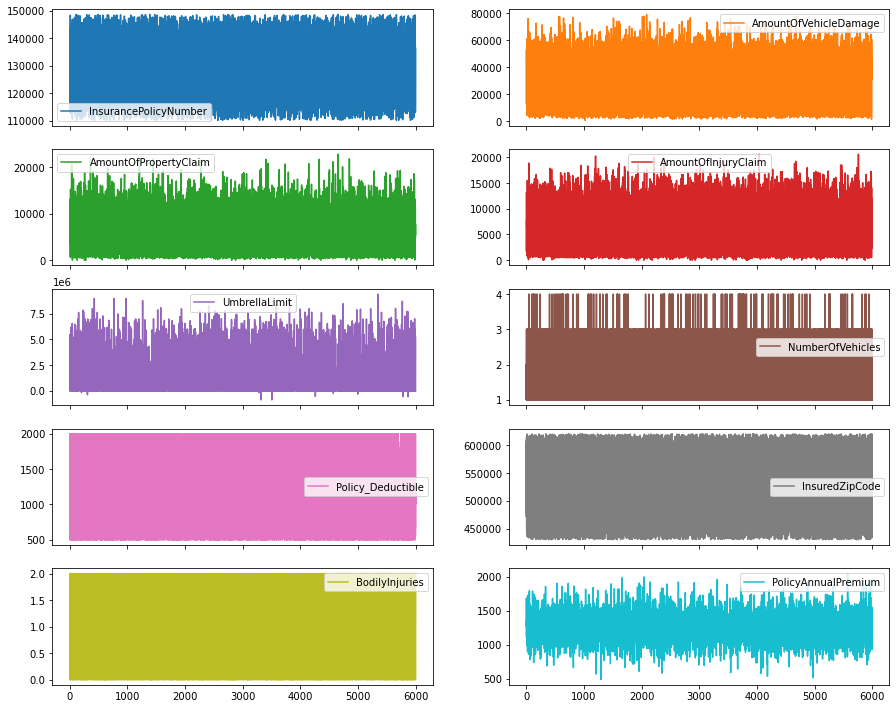

In [48]:
# plot features
p = 2
k = int(len(num)/p) +1
df[num].plot(subplots=True, layout=(k,p), figsize=(15,15))
plt.show()

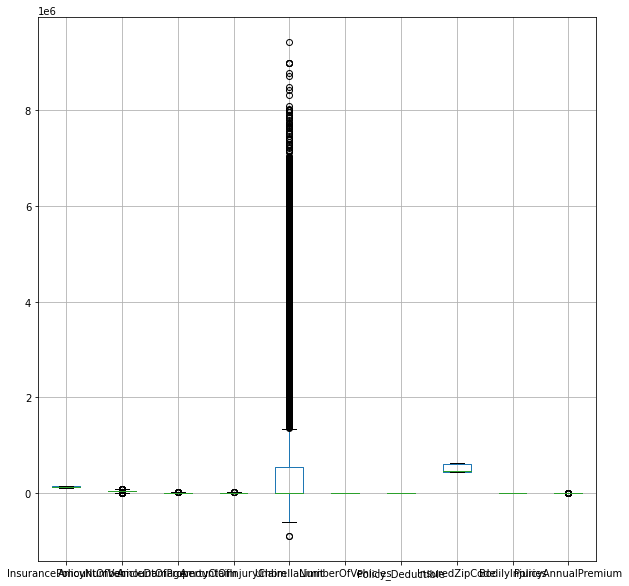

In [49]:
# box plot
df[num].boxplot(figsize=(10,10))
plt.show()

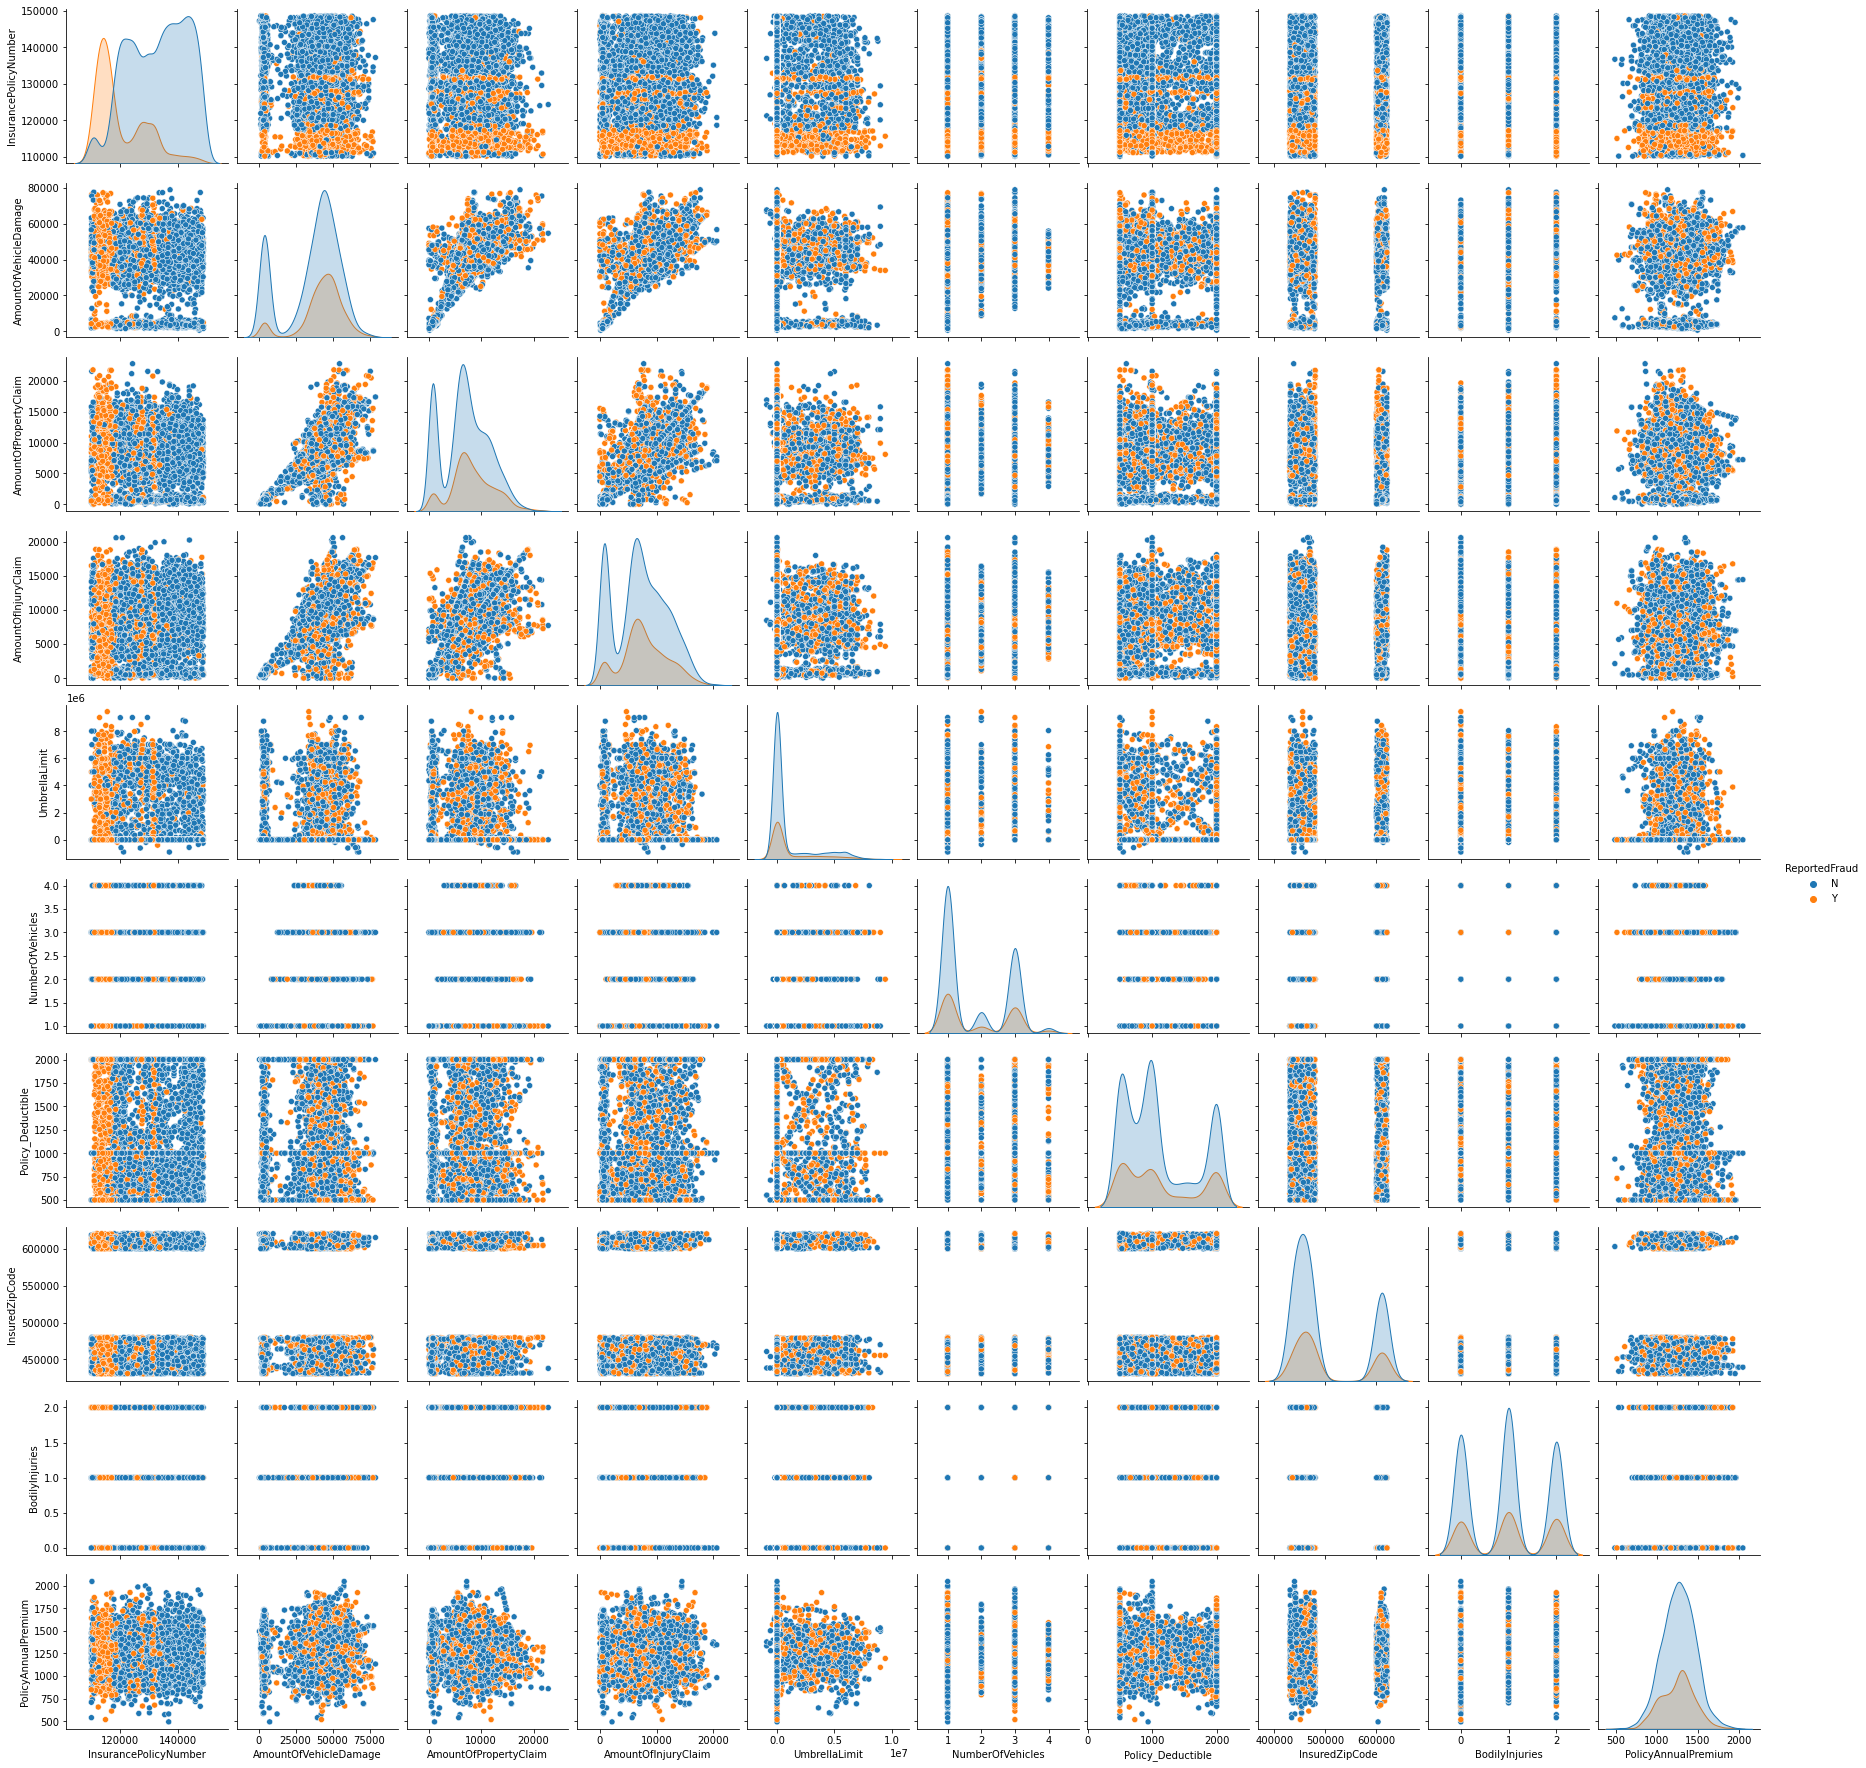

In [50]:
# pair plot
sns.pairplot(df[num], hue = target)

### Set data pipelines 

In [51]:
def buildpipe(name, model, num, cat):
    
    # sub pipeline numeric
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler())])
        
    # sub pipeline categorical
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))]) #OneHotEncoder(handle_unknown='ignore') #OrdinalEncoder()

    # map data types to their transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num),
            ("cat", categorical_transformer, cat)])

    # define main pipe main pipe
    mainpipe = Pipeline(steps=[
        ('preprocessor', preprocessor), (name, model)])

    return mainpipe, preprocessor

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 10


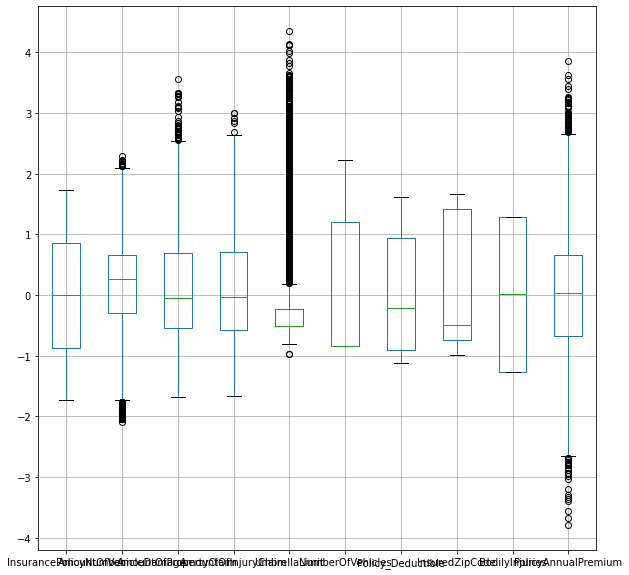

In [52]:
# check pipeline on numeric data
num = extract_num(df, target, keep_target=False, top_feature=10)

dfnum = df[num]

_ , preprocessor = buildpipe("naive bayes", GaussianNB(), num, cat=[])

x_scaled = preprocessor.fit_transform(dfnum)
        
dfx_scaled = pd.DataFrame(x_scaled, index=dfnum.index, columns=dfnum.columns)

# boxplot
dfx_scaled.boxplot(figsize=(10,10))
plt.show()

### Train 

In [53]:
def train(df_clean, target, model, name, param, shuffle=True, data="mixed", top_feat=None, test_size=0.1):
        
    X, y = df_clean.drop(columns=target), df_clean[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=shuffle)
    
    if data == "mixed":
        num, cat = extract_num(df_clean, target, keep_target=False, top_feature=top_feat), extract_cat(df_clean, target, keep_target=False, top_feature=top_feat)

    if data == "num":
        num, cat = extract_num(df_clean, target, keep_target=False, top_feature=top_feat), []
    
    if data == "cat":
        num, cat = [], extract_cat(df_clean, target, keep_target=False, top_feature=top_feat)
    
    if param is not None:
        
        keys = list(param)
        if type(param[keys[0]]) == list:
            grid_search = True
        else:
            grid_search = False
    
    if param is None:
        grid_search = False
        
    if grid_search:
        print("grid search " + name + ' for ' + data + " data ...")

        mainpipe, _ = buildpipe(name, model, num, cat)
                
        # create search object
        param_grid = {name+'__'+k:v for k, v in param.items()}
    
        grid = GridSearchCV(mainpipe,
                          param_grid=param_grid,
                          scoring='accuracy',
                          cv=None,
                          n_jobs=-1)

        # fit data
        model = grid.fit(X_train, y_train)
        
        
    if grid_search==False:
        print("fitting " + name + " with param : ", param)
        if param is not None:
            model = model.set_params(**param)

        mainpipe, _ = buildpipe(name, model, num, cat)

        # fit data     
        model = mainpipe.fit(X_train, y_train)
        
    # predict test data (and train data to check overfitting)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # calculate metrics
    if grid_search:
        print(name + " best param :" + str(model.best_params_))
    
    print('acc. train for ' + data + " data :" + str(accuracy_score(y_train, y_train_pred)))
    print('acc. test  for ' + data + " data :" + str(accuracy_score(y_test, y_test_pred)))
    print("")

    #Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
    fig, ax = plt.subplots(figsize=(10,10))
    cmp.plot(cmap=plt.cm.Blues, ax=ax)    
    plt.title(name + " + " + data + " data")

    return model

### Run  

In [54]:
param_grid_knn = {'n_neighbors':[3, 7, 21, 31]}
param_grid_svm = {'C': [0.1, 100], 'gamma': [0.01, 1]}
param_grid_tree = {'max_depth': [2, 6, 12]}
param_grid_lr = {"C":[0.01,1,100], "penalty":["l2", "none"]}
param_grid_rf = {'max_depth': [3,5,10],
           'min_samples_leaf': [1, 2, 4],
           'min_samples_split': [2, 5, 10],
           'n_estimators': [64, 256, 512]}

model_select = {
    "knn":KNeighborsClassifier(),
    "svm":SVC(kernel='rbf'),
    "tree":DecisionTreeClassifier(criterion="gini"),
    "naive bayes":GaussianNB(),
    "lr":LogisticRegression(solver="lbfgs", max_iter=1500),
    "rf": RandomForestClassifier(),
}

param_grid = {
    "knn":param_grid_knn,
    "svm":param_grid_svm,
    "tree":param_grid_tree,
    "naive bayes":None,
    "lr":param_grid_lr,
    "rf":param_grid_rf,

}

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 15
grid search knn for num data ...
knn best param :{'knn__n_neighbors': 7}
acc. train for num data :0.8987037037037037
acc. test  for num data :0.865

Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 20
grid search knn for cat data ...
knn best param :{'knn__n_neighbors': 3}
acc. train for cat data :0.9337037037037037
acc. test  for cat data :0.885

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 15
Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 20
grid search knn for mixed data ...
knn best param :{'knn__n_neighbors': 3}
acc. train for mixed data :0.9481481481481482
acc. test  for mixed data :0.9183333333333333



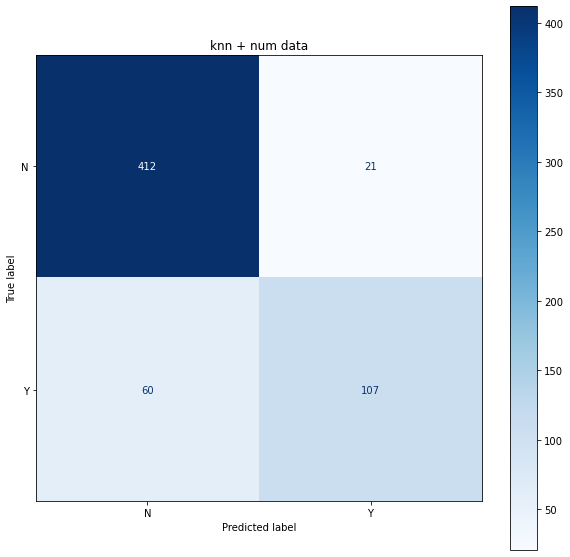

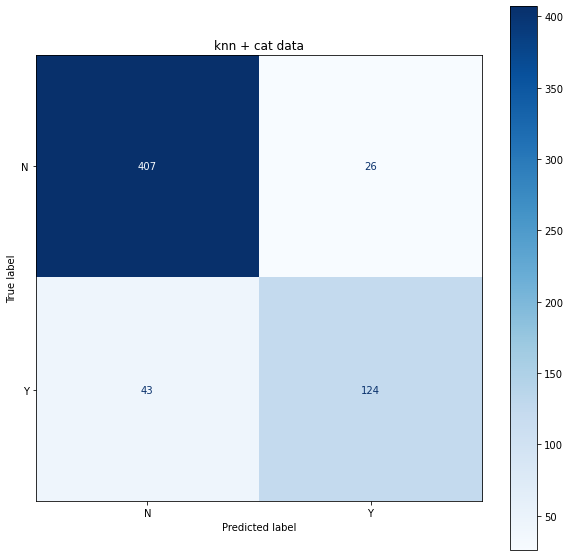

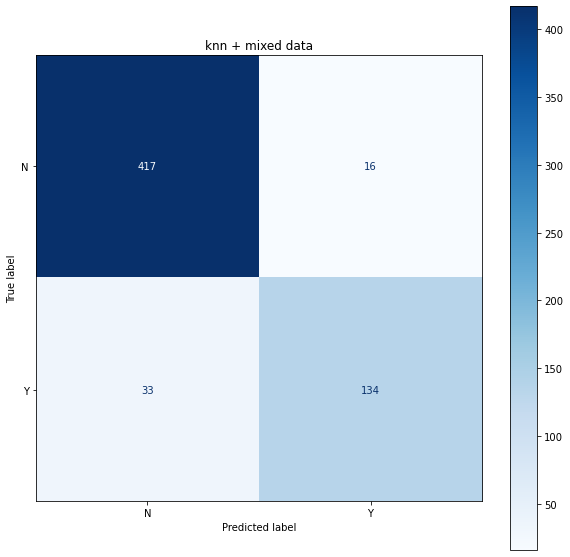

In [55]:
name = "knn"
model = model_select[name]
param = param_grid[name]

model = train(df, target, model_select[name], name, param, shuffle=True, data="num", top_feat=20, test_size=0.1)
model = train(df, target, model_select[name], name, param, shuffle=True, data="cat", top_feat=20, test_size=0.1)
model = train(df, target, model_select[name], name, param, shuffle=True, data="mixed", top_feat=20, test_size=0.1)

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 15
grid search svm for num data ...
svm best param :{'svm__C': 100, 'svm__gamma': 0.01}
acc. train for num data :0.8772222222222222
acc. test  for num data :0.8466666666666667

Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 20
grid search svm for cat data ...
svm best param :{'svm__C': 100, 'svm__gamma': 0.01}
acc. train for cat data :0.9807407407407407
acc. test  for cat data :0.9066666666666666

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 15
Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 20
grid search svm for mixed data ...
svm best param :{'svm__C': 100, 'svm__gamma': 0.01}
acc. train for mixed data :0.9998148148148148
acc. test  for mixed data :0.89



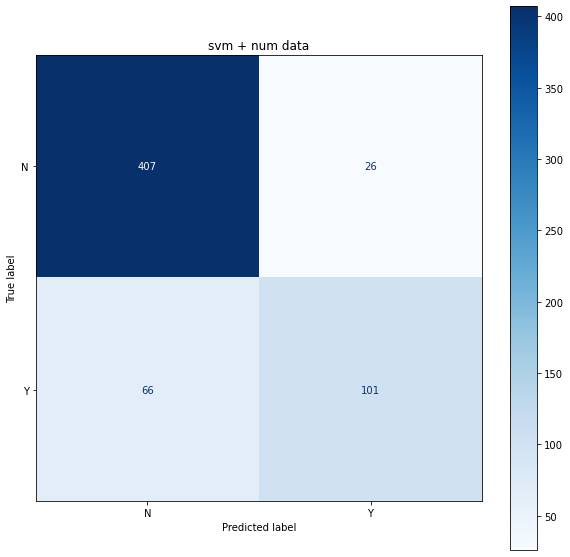

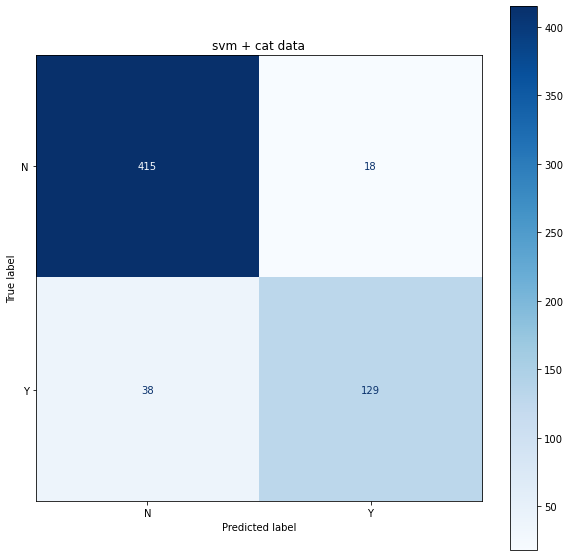

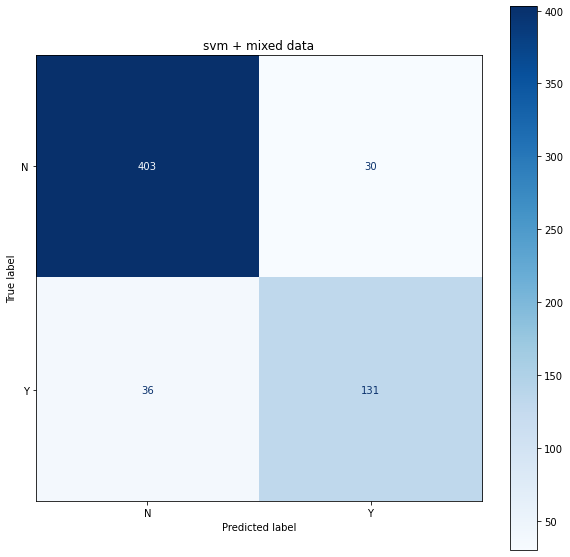

In [56]:
name = "svm"
model = model_select[name]
param = param_grid[name]

model = train(df, target, model_select[name], name, param, shuffle=True, data="num", top_feat=20, test_size=0.1)
model = train(df, target, model_select[name], name, param, shuffle=True, data="cat", top_feat=20, test_size=0.1)
model = train(df, target, model_select[name], name, param, shuffle=True, data="mixed", top_feat=20, test_size=0.1)

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 15
grid search tree for num data ...
tree best param :{'tree__max_depth': 6}
acc. train for num data :0.9301851851851852
acc. test  for num data :0.905

Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 20
grid search tree for cat data ...
tree best param :{'tree__max_depth': 12}
acc. train for cat data :0.8664814814814815
acc. test  for cat data :0.83

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 15
Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 20
grid search tree for mixed data ...
tree best param :{'tree__max_depth': 6}
acc. train for mixed data :0.9248148148148149
acc. test  for mixed data :0.895



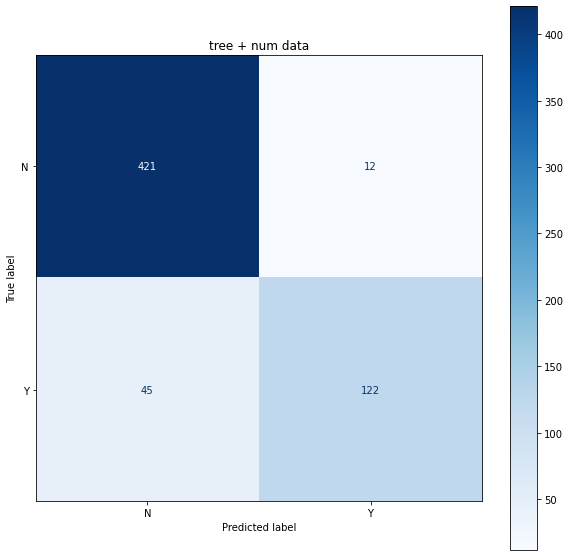

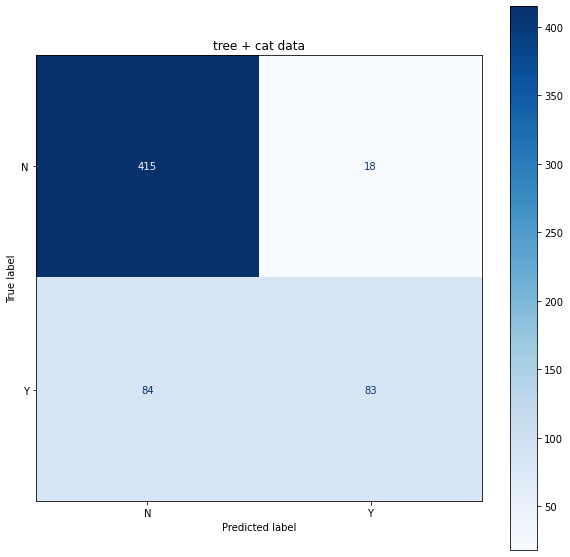

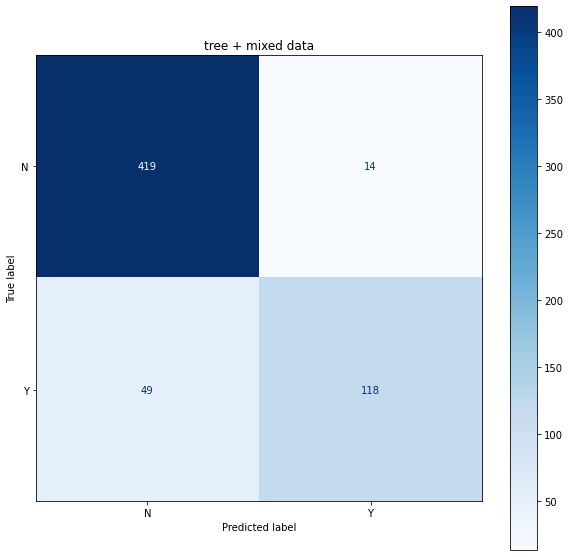

In [57]:
name = "tree"
model = model_select[name]
param = param_grid[name]

model = train(df, target, model_select[name], name, param, shuffle=True, data="num", top_feat=20, test_size=0.1)
model = train(df, target, model_select[name], name, param, shuffle=True, data="cat", top_feat=20, test_size=0.1)
model = train(df, target, model_select[name], name, param, shuffle=True, data="mixed", top_feat=20, test_size=0.1)

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 15
fitting naive bayes with param :  None
acc. train for num data :0.7853703703703704
acc. test  for num data :0.79



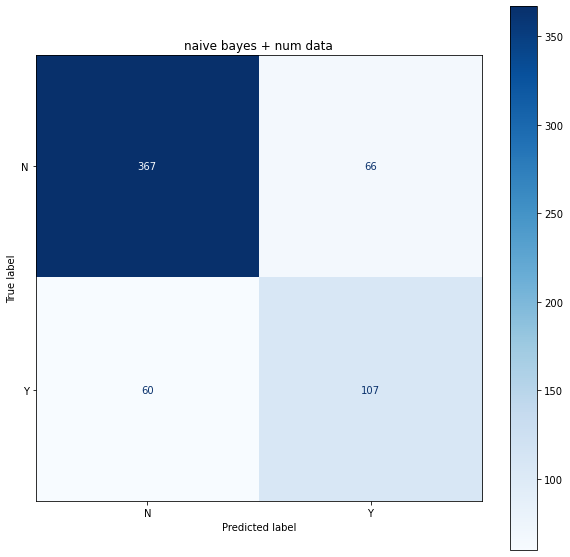

In [58]:
name = "naive bayes"
model = model_select[name]
param = param_grid[name]

model = train(df, target, model_select[name], name, param, shuffle=True, data="num", top_feat=20, test_size=0.1)
# maives bayes is based on numeric data

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 15
grid search lr for num data ...
lr best param :{'lr__C': 0.01, 'lr__penalty': 'l2'}
acc. train for num data :0.8340740740740741
acc. test  for num data :0.825

Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 20
grid search lr for cat data ...
lr best param :{'lr__C': 100, 'lr__penalty': 'l2'}
acc. train for cat data :0.9487037037037037
acc. test  for cat data :0.91

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 15
Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 20
grid search lr for mixed data ...
lr best param :{'lr__C': 100, 'lr__penalty': 'l2'}
acc. train for mixed data :0.9503703703703704
acc. test  for mixed data :0.91



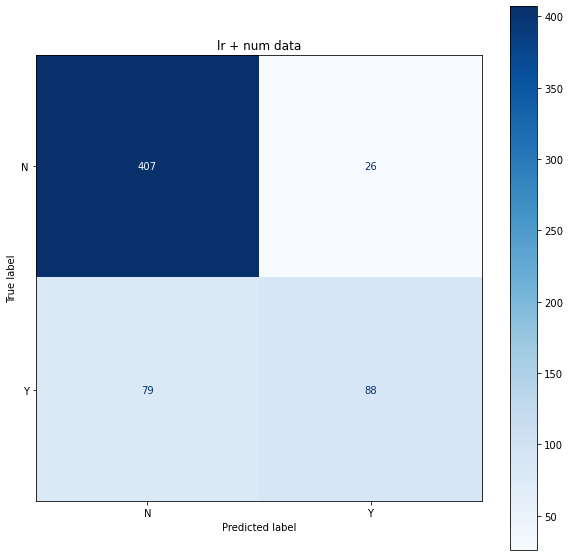

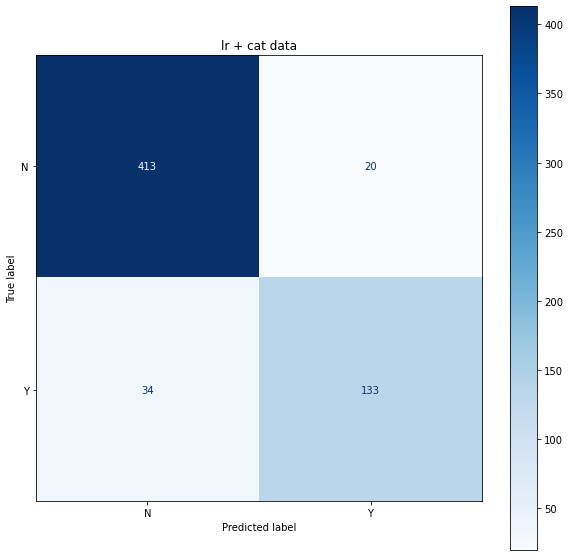

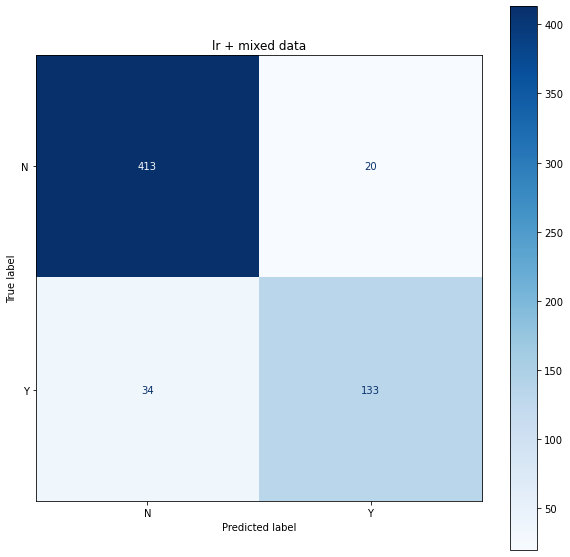

In [59]:
name = "lr" # logistic regression
model = model_select[name]
param = param_grid[name]

model = train(df, target, model_select[name], name, param, shuffle=True, data="num", top_feat=20, test_size=0.1)
model = train(df, target, model_select[name], name, param, shuffle=True, data="cat", top_feat=20, test_size=0.1)
model = train(df, target, model_select[name], name, param, shuffle=True, data="mixed", top_feat=20, test_size=0.1)

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 15
grid search rf for num data ...
rf best param :{'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 64}
acc. train for num data :0.9112962962962963
acc. test  for num data :0.8783333333333333

Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 20
grid search rf for cat data ...
rf best param :{'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 64}
acc. train for cat data :0.7368518518518519
acc. test  for cat data :0.725

Total Nr numerical features in initial dataset : 15
Nr of numerical features for training : 15
Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 20
grid search rf for mixed data ...
rf best param :{'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 64}
a

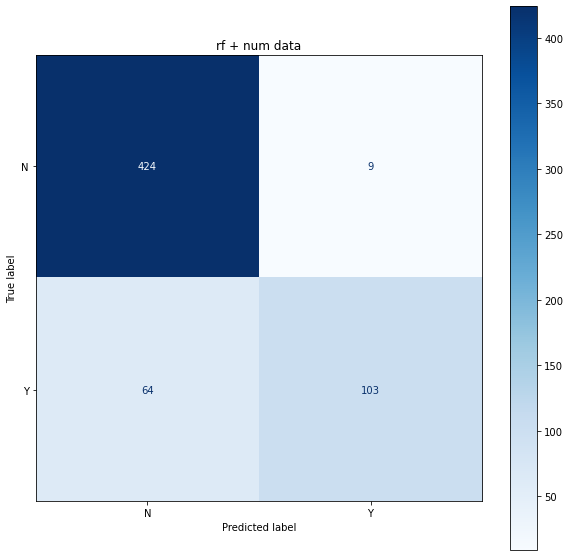

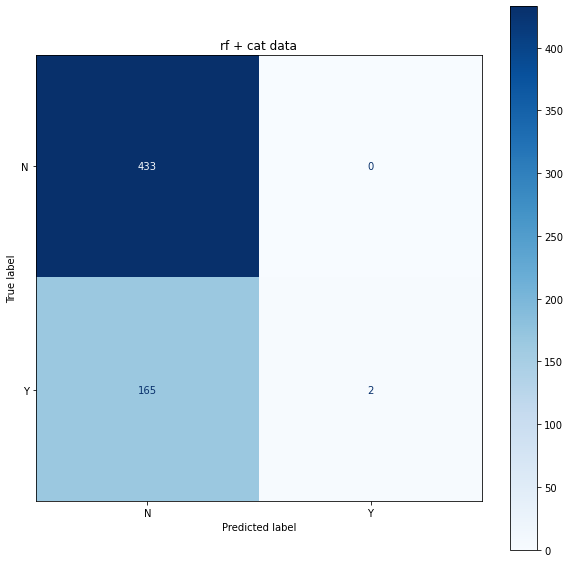

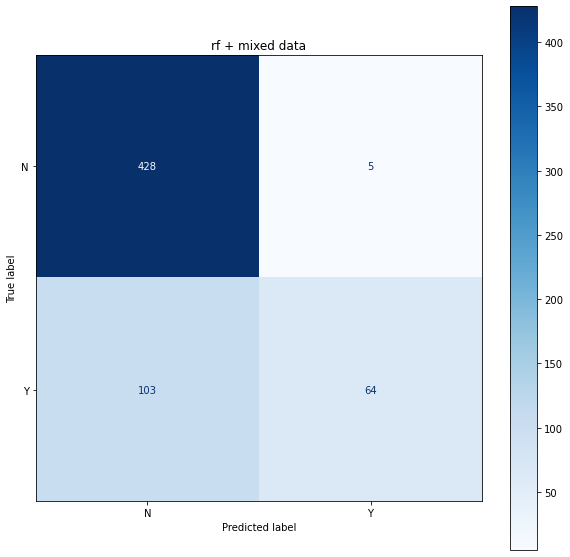

In [60]:
name = "rf" # random forest
model = model_select[name]
param = param_grid[name]

model = train(df, target, model_select[name], name, param, shuffle=True, data="num", top_feat=20, test_size=0.1)
model = train(df, target, model_select[name], name, param, shuffle=True, data="cat", top_feat=20, test_size=0.1)
model = train(df, target, model_select[name], name, param, shuffle=True, data="mixed", top_feat=20, test_size=0.1)

### Conclusion

Accuracy is not the best metrics for unbalanced dataset but this gives us a trend of the performance.
Among the different models, logistic regression has the best True Positive (around 130):

Logistic regression:  
acc. train for num data :0.832  
acc. test  for num data :0.828  

acc. train for cat data :0.951  
acc. test  for cat data :0.935  

acc. train for mixed data :0.952  
acc. test  for mixed data :0.933  

Running time of Logistic regression is also good compared to SVM or Random Forest.  

The accuracy is mostly better on categorical data for all models. 
We could decide remove numerical feature to go in production, thus lightening the model.  

Let's run logistic regression with by changing "top_feat" parameter (number of feature taken to train model).

we see that the performance are almost identical between 20 and 15 features so we will retain the following 15 features to explain the model :

['TypeOfIncident',
 'TypeOfCollission',
 'SeverityOfIncident',
 'AuthoritiesContacted',
 'IncidentState',
 'IncidentCity',
 'IncidentAddress',
 'PoliceReport',
 'InsuredEducationLevel',
 'InsuredOccupation',
 'Country',
 'InsurancePolicyState',
 'Policy_CombinedSingleLimit',
 'VehicleAttribute2',
 'VehicleAttribute4']

Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 15
grid search lr for cat data ...
lr best param :{'lr__C': 100, 'lr__penalty': 'l2'}
acc. train for cat data :0.9496296296296296
acc. test  for cat data :0.91

Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 20
grid search lr for cat data ...
lr best param :{'lr__C': 100, 'lr__penalty': 'l2'}
acc. train for cat data :0.9487037037037037
acc. test  for cat data :0.91

Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 25
grid search lr for cat data ...
lr best param :{'lr__C': 100, 'lr__penalty': 'l2'}
acc. train for cat data :0.9524074074074074
acc. test  for cat data :0.9



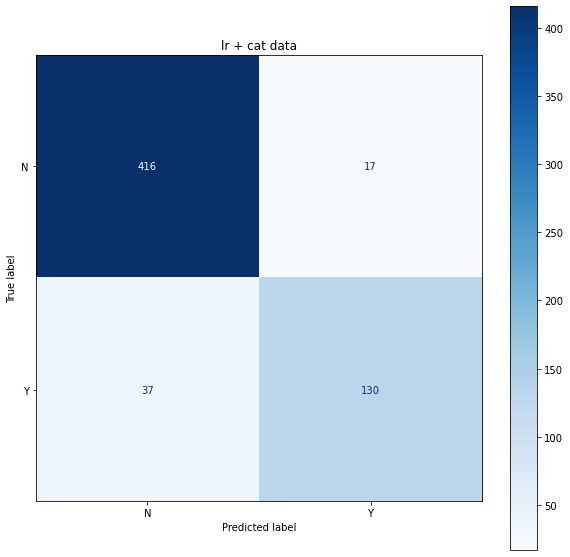

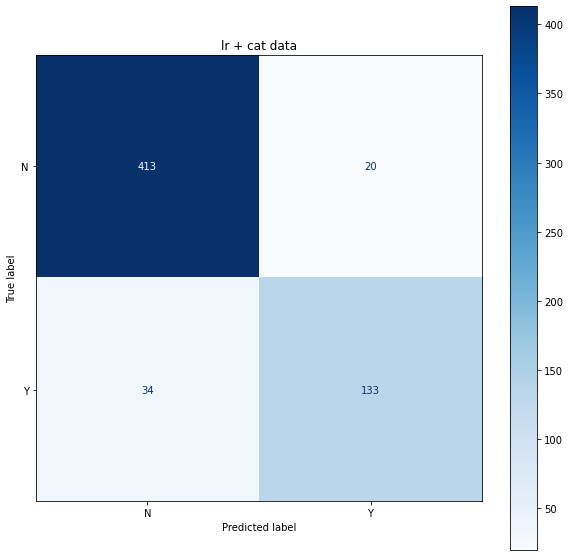

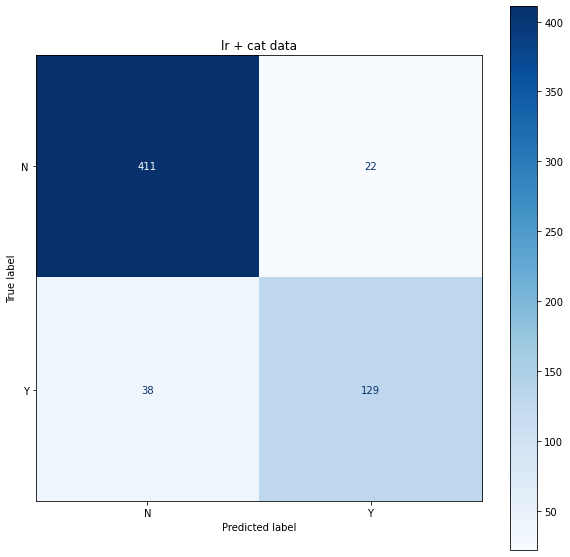

In [61]:
name = "lr" # logistic regression
model = model_select[name]
param = param_grid[name]

model = train(df, target, model_select[name], name, param, shuffle=True, data="cat", top_feat=15, test_size=0.1)
model = train(df, target, model_select[name], name, param, shuffle=True, data="cat", top_feat=20, test_size=0.1)
model = train(df, target, model_select[name], name, param, shuffle=True, data="cat", top_feat=25, test_size=0.1)


In [62]:
cat = extract_cat(df, target, keep_target=False, top_feature=15)
cat

Total Nr categorical features in initial dataset : 31
Nr of categorical features for training : 15


['DateOfIncident',
 'TypeOfIncident',
 'TypeOfCollission',
 'SeverityOfIncident',
 'AuthoritiesContacted',
 'IncidentCity',
 'IncidentAddress',
 'Witnesses',
 'PoliceReport',
 'InsuredEducationLevel',
 'Country',
 'InsurancePolicyState',
 'Policy_CombinedSingleLimit',
 'VehicleAttribute2',
 'VehicleAttribute4']